In [ ]:
!pip install  torchtoolbox #efficientnet_pytorch

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
#import albumentations as A
#from albumentations.pytorch.transforms import ToTensor
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
# from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [ ]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# [Melanoma classification](https://www.kaggle.com/c/siim-isic-melanoma-classification/overview)

# 1 Посмотрим на данные

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
train_df = pd.read_csv("./gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/data/train.csv")
test_df = pd.read_csv("./gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/data/test.csv")

In [ ]:
train_df.head()

In [ ]:
test_df.info

In [ ]:
print(f"The total patient ids are {train_df['patient_id'].count()}, from those the unique ids are {train_df['patient_id'].value_counts().shape[0]} ")

In [ ]:
train_df['target'].value_counts()

In [ ]:
train_images = "./gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/data/train"
test_images = "./gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/data/test"

In [ ]:
# Total number of images in the dataset(train+test)
print("Total images in Train set: ",train_df['image_name'].count())
print("Total images in Test set: ",test_df['image_name'].count())

In [ ]:
im_path = str(train_images + "/" + train_df.iloc[0]['image_name'] + '.jpg')

In [ ]:
im_path

'./gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/data/train/ISIC_2637011.jpg'

In [ ]:
x = cv2.imread(im_path)

In [ ]:
x

In [ ]:
def disp_img(dataframe):
  images = dataframe['image_name'].values

  # Extract 9 random images from it
  random_images = [np.random.choice(images+'.jpg') for i in range(9)]

  print('Display Random Images')

  # Adjust the size of your images
  plt.figure(figsize=(10,8))

  # Iterate and plot random images
  for i in range(9):
      plt.subplot(3, 3, i + 1)
      img = plt.imread(os.path.join(train_images, random_images[i]))
      plt.imshow(img, cmap='gray')
      plt.axis('off')
      
  # Adjust subplot parameters to give specified padding
  plt.tight_layout()  

In [ ]:
disp_img(train_df)

In [ ]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']

In [ ]:
disp_img(benign)

In [ ]:
disp_img(malignant)

# 2 Три пути решения задачи
- Детерминированные подходы на основе формализованных правил + статистика
- [Пусть нейросети сами как-то](https://www.kaggle.com/saife245/melanoma-detail-analysis-eda-ip-augmentation-model)
- Нейросети + помощь от разработчика

# 3 На этом этапе стоит обратиться к [доменной области](https://www.kaggle.com/saife245/melanoma-detail-analysis-eda-ip-augmentation-model) для большего понимания проблемы

**Что делать с метаданными и какие аугментации применять?**

# 4 Нейросетевой подход. Подготовка данных

## 4.1 Предобработка Meta данных

In [ ]:
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)

dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')

train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})

train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()

train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [ ]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [ ]:
meta_features

In [ ]:
train_df.head()

## 4.2 Создадим Датасет

In [ ]:
class MelanomaDataset(Dataset):
    def __init__()
        
    def __getitem__(self, index):
    
    def __len__(self):

## 4.3 Задаем преобразования

### 4.3.1 Классические аугментации

In [ ]:
train_transform = 

test_transform = 

In [ ]:
test = 

In [ ]:
train_idx = [1, 2, 3]
val_idx = [4, 5, 6]

In [ ]:
train = 
val = 

In [ ]:
train.__len__()

3

### 4.3.2 Волосы

Добавление волос

In [ ]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

### 4.3.3 Микроскоп

Обрезание по кругу

In [ ]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

### 4.3.4 Масштабирование

Идеи:

### 4.3.5 Анализ последовательности снимков

Идеи:

### 4.3.6 Пересчет параметров нормализации

Часто может помочь пересчитать матожидание и дисперсию по каждому каналу для текущих данных

### 4.3.7 Обновим преобразования

In [ ]:
train_transform = 
test_transform = 

# 5 Подготовка и обучение нейросети

## 5.1 Собираем архитектуру

In [ ]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
resnet18.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        
        return output

In [ ]:
model = Net(arch=resnet18, n_meta_features=len(meta_features))

In [ ]:
params = list(model.parameters())
print(len(params))
print(params[71])

72
Parameter containing:
tensor([-0.0210], requires_grad=True)


## 5.2 Обучим модель

In [ ]:
epochs = 3  # Number of epochs to run
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 1 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

skf = KFold(n_splits=2, shuffle=True, random_state=47)

### 5.2.1 Создадим train/val/test подвыборки

In [ ]:
train_len = 500
train_df = train_df.iloc[:train_len]

train_idx = np.linspace(0, train_len-51, num=train_len-50, dtype=int)
val_idx = np.linspace(train_len-50, train_len-1, num=50, dtype=int)

In [ ]:
train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                        imfolder=train_images, 
                        train=True, 
                        transforms=train_transform,
                        meta_features=meta_features)

val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                        imfolder=train_images, 
                        train=True, 
                        transforms=test_transform,
                        meta_features=meta_features)

test = MelanomaDataset(df=test_df.iloc[:500], # изменить здесь, чтобы сделать сабмит
                       imfolder=test_images, 
                       train=False,
                       transforms=train_transform,  # For TTA
                       meta_features=meta_features)

In [ ]:
train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)

### 5.2.2 Создадим модель

In [ ]:
best_val = 0  # Best validation score within this fold
patience = es_patience  # Current patience counter

arch = models.resnet18(pretrained=True)
model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
criterion = nn.BCEWithLogitsLoss()

model.train();

### 5.2.3 Цикл обучения

In [ ]:
correct = 0
epoch_loss = 0

for x, y in train_loader:
  ##################### достаем батч #####################
  x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
  x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
  y = torch.tensor(y, device=device, dtype=torch.float32)

  ##################### считаем ошибку #####################
  optim.zero_grad()
  z = model(x)
  loss = criterion(z, y.unsqueeze(1))
  loss.backward()
  optim.step()
  pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
  correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
  epoch_loss += loss.item()

train_acc = correct / len(train_idx)

print(epoch_loss, train_acc)

2.010782007858225 0.976


### 5.2.4 Валидация

In [ ]:
val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
model_path = './gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/models/model.pth'  # Path and filename to save model to
with torch.no_grad():  # Do not calculate gradient since we are only predicting
    # Predicting on validation set
    for j, (x_val, y_val) in enumerate(val_loader):
      ##################### достаем батч #####################
        x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
        x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
        y_val = torch.tensor(y_val, device=device, dtype=torch.float32)

        ##################### считаем точность на валидации #####################
        z_val = model(x_val)
        val_pred = torch.sigmoid(z_val)
        val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred

    val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
    val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
    
    print(val_acc, val_roc)

    scheduler.step(val_roc)
        
    if val_roc >= best_val:
        best_val = val_roc
        patience = es_patience  # Resetting patience since we have new best validation accuracy
        torch.save(model, model_path)  # Saving current best model
    else:
        patience -= 1
        if patience == 0:
            print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))

0.988 0.5195681511470984


 ### 5.2.5 Сделаем предсказание

In [ ]:
model.eval()  # switch model to the evaluation mode
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test
TTA = 3 # Test Time Augmentation rounds

with torch.no_grad():
    # Predicting on test set
    tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
    for t in range(TTA):
        print( '  TTA', t)

        for i, x_test in enumerate(tqdm(test_loader)):
            x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
            x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
            
            z_test = model(x_test)
            
            z_test = torch.sigmoid(z_test)
            
            tta_preds[i*test_loader.batch_size:i*test_loader.batch_size + x_test[0].shape[0]] += z_test
    preds += tta_preds / TTA


  TTA 0


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


  TTA 1


100%|██████████| 32/32 [00:11<00:00,  2.87it/s]


  TTA 2


100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


### 5.2.6 Обучение на K фолдах (stratified k fold)

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)  
    
    ##################### создаем модель #####################
    model_path = f'./gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/models/model_{fold}.pth'  # Path and filename to save model to
    best_val = 0  # Best validation score within this fold
    patience = es_patience  # Current patience counter

    arch = models.resnet18(pretrained=True)
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()

    ##################### выделяем валидационную выборку #####################
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder=train_images, 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder=train_images, 
                            train=True, 
                            transforms=test_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)

    ##################### цикл обучения #####################
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        ##################### одна эпоха обучения #####################
        for x, y in train_loader:
            ##################### достаем батч #####################
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            ##################### считаем ошибку #####################
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()

        ##################### считаем точность на тренировке #####################
        train_acc = correct / len(train_idx)
        
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
              ##################### достаем батч #####################
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)

                ##################### считаем точность на валидации #####################
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
       
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
      
        # Predicting on test set
        tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                tta_preds[i*test_loader.batch_size:i*test_loader.batch_size + x_test[0].shape[0]] += z_test
        preds += tta_preds / TTA
    
preds /= skf.n_splits

==================== Fold 1 ====================
Epoch 001: | Loss: 2.484 | Train acc: 0.968 | Val acc: 0.988 | Val roc_auc: 0.684 | Training time: 0:00:15
==================== Fold 2 ====================
Epoch 001: | Loss: 2.437 | Train acc: 0.968 | Val acc: 0.988 | Val roc_auc: 0.447 | Training time: 0:00:08


## Делаем submit

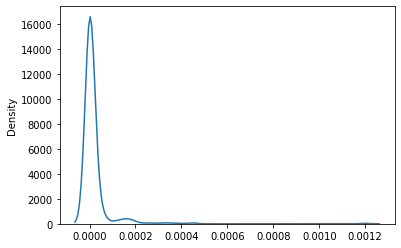

In [ ]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

In [ ]:
sub = pd.read_csv('./gdrive/My Drive/Colab Notebooks/ML/семестр2/Семинар 06 - kaggle practice/data/sample_submission.csv')
sub['target'] = preds.cpu().numpy().reshape(-1,)
sub.to_csv('submission.csv', index=False)

ValueError: ignored